<a href="https://colab.research.google.com/github/jtsu03/Yelp-Review-NLP-Business-Insights-Analysis/blob/main/Yelp_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import pandas as pd
import numpy as np

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
yelp2 = pd.read_json("/content/drive/MyDrive/CRM projec/yelp_academic_dataset_review.json", lines=True)

In [ ]:
yelp1 = pd.read_json("/content/drive/MyDrive/CRM projec/yelp_academic_dataset_business.json", lines=True)

In [ ]:
yelp1.head(5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."


In [ ]:
yelp2.head ()

,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15


In [ ]:
yelp2 = yelp2.rename(columns={"stars": "review_stars"})

In [ ]:
yelp2

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15
...,...,...,...,...,...,...,...,...,...
6990275,H0RIamZu0B0Ei0P4aeh3sQ,qskILQ3k0I_qcCMI-k6_QQ,jals67o91gcrD4DC81Vk6w,5,1,2,1,Latest addition to services from ICCU is Apple...,2014-12-17 21:45:20
6990276,shTPgbgdwTHSuU67mGCmZQ,Zo0th2m8Ez4gLSbHftiQvg,2vLksaMmSEcGbjI5gywpZA,5,2,1,2,"This spot offers a great, affordable east week...",2021-03-31 16:55:10
6990277,YNfNhgZlaaCO5Q_YJR4rEw,mm6E4FbCMwJmb7kPDZ5v2Q,R1khUUxidqfaJmcpmGd4aw,4,1,0,0,This Home Depot won me over when I needed to g...,2019-12-30 03:56:30
6990278,i-I4ZOhoX70Nw5H0FwrQUA,YwAMC-jvZ1fvEUum6QkEkw,Rr9kKArrMhSLVE9a53q-aA,5,1,0,0,For when I'm feeling like ignoring my calorie-...,2022-01-19 18:59:27


In [ ]:
yelp1 = yelp1.rename(columns={"stars": "business_stars"})

In [ ]:
yelp1

,business_id,name,address,city,state,postal_code,latitude,longitude,business_stars,review_count,is_open,attributes,categories,hours
0,Pns2l4eNsfO8kk83dixA6A,"Abby Rappoport, LAC, CMQ","1616 Chapala St, Ste 2",Santa Barbara,CA,93101,34.426679,-119.711197,5.0,7,0,{'ByAppointmentOnly': 'True'},"Doctors, Traditional Chinese Medicine, Naturop...",None
1,mpf3x-BjTdTEA3yCZrAYPw,The UPS Store,87 Grasso Plaza Shopping Center,Affton,MO,63123,38.551126,-90.335695,3.0,15,1,{'BusinessAcceptsCreditCards': 'True'},"Shipping Centers, Local Services, Notaries, Ma...","{'Monday': '0:0-0:0', 'Tuesday': '8:0-18:30', ..."
2,tUFrWirKiKi_TAnsVWINQQ,Target,5255 E Broadway Blvd,Tucson,AZ,85711,32.223236,-110.880452,3.5,22,0,"{'BikeParking': 'True', 'BusinessAcceptsCredit...","Department Stores, Shopping, Fashion, Home & G...","{'Monday': '8:0-22:0', 'Tuesday': '8:0-22:0', ..."
3,MTSW4McQd7CbVtyjqoe9mw,St Honore Pastries,935 Race St,Philadelphia,PA,19107,39.955505,-75.155564,4.0,80,1,"{'RestaurantsDelivery': 'False', 'OutdoorSeati...","Restaurants, Food, Bubble Tea, Coffee & Tea, B...","{'Monday': '7:0-20:0', 'Tuesday': '7:0-20:0', ..."
4,mWMc6_wTdE0EUBKIGXDVfA,Perkiomen Valley Brewery,101 Walnut St,Green Lane,PA,18054,40.338183,-75.471659,4.5,13,1,"{'BusinessAcceptsCreditCards': 'True', 'Wheelc...","Brewpubs, Breweries, Food","{'Wednesday': '14:0-22:0', 'Thursday': '16:0-2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
150341,IUQopTMmYQG-qRtBk-8QnA,Binh's Nails,3388 Gateway Blvd,Edmonton,AB,T6J 5H2,53.468419,-113.492054,3.0,13,1,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...","Nail Salons, Beauty & Spas","{'Monday': '10:0-19:30', 'Tuesday': '10:0-19:3..."
150342,c8GjPIOTGVmIemT7j5_SyQ,Wild Birds Unlimited,2813 Bransford Ave,Nashville,TN,37204,36.115118,-86.766925,4.0,5,1,"{'BusinessAcceptsCreditCards': 'True', 'Restau...","Pets, Nurseries & Gardening, Pet Stores, Hobby...","{'Monday': '9:30-17:30', 'Tuesday': '9:30-17:3..."
150343,_QAMST-NrQobXduilWEqSw,Claire's Boutique,"6020 E 82nd St, Ste 46",Indianapolis,IN,46250,39.908707,-86.065088,3.5,8,1,"{'RestaurantsPriceRange2': '1', 'BusinessAccep...","Shopping, Jewelry, Piercing, Toy Stores, Beaut...",None
150344,mtGm22y5c2UHNXDFAjaPNw,Cyclery & Fitness Center,2472 Troy Rd,Edwardsville,IL,62025,38.782351,-89.950558,4.0,24,1,"{'BusinessParking': '{'garage': False, 'street...","Fitness/Exercise Equipment, Eyewear & Optician...","{'Monday': '9:0-20:0', 'Tuesday': '9:0-20:0', ..."


In [ ]:
merged_df = pd.merge(
    yelp2,        # review dataset
    yelp1,        # business dataset
    on="business_id",
    how="inner"   # keeps only matching business_id rows
)


In [ ]:
merged_df.head(5)

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,...,state,postal_code,latitude,longitude,business_stars,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,...,PA,19454,40.210196,-75.223639,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,...,PA,19119,39.952103,-75.172753,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,...,AZ,85713,32.207233,-110.980864,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,...,PA,19114,40.079848,-75.025080,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,...,LA,70119,29.962102,-90.087958,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


In [ ]:
merged_df.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'address', 'city', 'state',
       'postal_code', 'latitude', 'longitude', 'business_stars',
       'review_count', 'is_open', 'attributes', 'categories', 'hours'],
      dtype='object')

In [ ]:
merged_df = merged_df.drop(columns=["longitude", "latitude", "address"])

In [ ]:
merged_df.head(5)

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,city,state,postal_code,business_stars,review_count,is_open,attributes,categories,hours
0,KU_O5udG6zpxOg-VcAEodg,mh_-eMZ6K5RLWhZyISBhwA,XQfwVwDr-v0ZS3_CbbE5Xw,3,0,0,0,"If you decide to eat here, just be aware it is...",2018-07-07 22:09:11,Turning Point of North Wales,North Wales,PA,19454,3.0,169,1,"{'NoiseLevel': 'u'average'', 'HasTV': 'False',...","Restaurants, Breakfast & Brunch, Food, Juice B...","{'Monday': '7:30-15:0', 'Tuesday': '7:30-15:0'..."
1,BiTunyQ73aT9WBnpR9DZGw,OyoGAe7OKpv6SyGZT5g77Q,7ATYjTIgM3jUlt4UM3IypQ,5,1,0,1,I've taken a lot of spin classes over the year...,2012-01-03 15:28:18,Body Cycle Spinning Studio,Philadelphia,PA,19119,5.0,144,0,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo...","Active Life, Cycling Classes, Trainers, Gyms, ...","{'Monday': '6:30-20:30', 'Tuesday': '6:30-20:3..."
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,Tucson,AZ,85713,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,Philadelphia,PA,19114,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,New Orleans,LA,70119,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."


In [ ]:
merged_df["city"].value_counts().head(10)


,count
city,
Philadelphia,967552
New Orleans,635364
Tampa,454889
Nashville,451571
Tucson,404880
Indianapolis,361489
Reno,351573
Santa Barbara,269630
Saint Louis,253437


In [ ]:
top10_cities = [
    "Philadelphia",
    "New Orleans",
    "Tampa",
    "Nashville",
    "Tucson",
    "Indianapolis",
    "Reno",
    "Santa Barbara",
    "Saint Louis",
    "Boise"
]


In [ ]:
top10_df = merged_df[merged_df["city"].isin(top10_cities)]


In [ ]:
len(top10_df)

4255751

In [ ]:
cats = top10_df["categories"].str.split(",", expand=False)

In [ ]:
cats_exploded = cats.explode().str.strip()


In [ ]:
category_counts = cats_exploded.value_counts()

In [ ]:
category_counts


,count
categories,
Restaurants,2900626
Food,1146850
Nightlife,1054849
Bars,992229
American (New),665698
...,...
Waldorf Schools,5
Outdoor Movies,5
Ceremonial Clothing,5


In [ ]:
pd.set_option("display.max_rows", None)

display(category_counts)

,count
categories,
Restaurants,2900626
Food,1146850
Nightlife,1054849
Bars,992229
American (New),665698
American (Traditional),598258
Breakfast & Brunch,582972
Sandwiches,430673
Event Planning & Services,403418


In [ ]:
import re

# Build a regex pattern for restaurant/food-related categories
restaurant_pattern = r"""
Restaurant|Restaurants|
Food|
Breakfast|Brunch|
Cafe|Cafes|
Coffee|Tea|
Bakery|Bakeries|
Dessert|Ice Cream|Frozen Yogurt|Gelato|
Pizza|Burgers|Sandwiches|Soup|Salad|
Seafood|Steak|Steakhouses|
BBQ|Barbeque|
Diner|Fast Food|
Mexican|Italian|Chinese|Japanese|Sushi|Korean|Thai|Vietnamese|
Mediterranean|Greek|Indian|Latin American|Cajun/Creole|Soul Food|
Tapas|Ramen|Noodles|Tacos|Pho|Kebab|
Vegan|Vegetarian|Gluten[- ]?Free|
Donuts|Bagels|Candy Stores|Chocolatiers|
Juice Bars|Smoothies|
Food Trucks|Food Stands|Street Vendors|
Poke|
Cheesesteaks|
Buffets|
Gastropubs|Beer Bar|Beer Hall|
Wine Bars|Brewpubs|Breweries|
Patisserie|Cake Shop|
Halal|Kosher|
Farmers Market|Health Markets|Ethnic Food|Grocery|Meat Shops
"""

# strip whitespace/newlines in the pattern string
restaurant_pattern = re.sub(r"\s+", "", restaurant_pattern)

# category_counts is a Series where the index is the category name
restaurant_category_counts = category_counts[
    category_counts.index.to_series().str.contains(restaurant_pattern, case=False, regex=True)
]

# Optional: see the top restaurant-related categories
restaurant_category_counts.head(50)


,count
categories,
Restaurants,2900626
Food,1146850
Breakfast & Brunch,582972
Sandwiches,430673
Seafood,381456
Coffee & Tea,300107
Mexican,266051
Burgers,254401
Pizza,243238


In [ ]:
def is_restaurant(cat_string):
    if not isinstance(cat_string, str):
        return False
    return bool(re.search(restaurant_pattern, cat_string, flags=re.IGNORECASE))

restaurants_df = top10_df[top10_df["categories"].apply(is_restaurant)].copy()


In [ ]:
restaurants_df.head()

,review_id,user_id,business_id,review_stars,useful,funny,cool,text,date,name,city,state,postal_code,business_stars,review_count,is_open,attributes,categories,hours
2,saUsX_uimxRlCVr67Z4Jig,8g_iMtfSiwikVnbP2etR0A,YjUWPpI6HXG530lwP-fb2A,3,0,0,0,Family diner. Had the buffet. Eclectic assortm...,2014-02-05 20:30:30,Kettle Restaurant,Tucson,AZ,85713,3.5,47,1,"{'RestaurantsReservations': 'True', 'BusinessP...","Restaurants, Breakfast & Brunch",None
3,AqPFMleE6RsU23_auESxiA,_7bHUi9Uuf5__HHc_Q8guQ,kxX2SOes4o-D3ZQBkiMRfA,5,1,0,1,"Wow! Yummy, different, delicious. Our favo...",2015-01-04 00:01:03,Zaika,Philadelphia,PA,19114,4.0,181,1,"{'Caters': 'True', 'Ambience': '{'romantic': F...","Halal, Pakistani, Restaurants, Indian","{'Tuesday': '11:0-21:0', 'Wednesday': '11:0-21..."
4,Sx8TMOWLNuJBWer-0pcmoA,bcjbaE6dDog4jkNY91ncLQ,e4Vwtrqf-wpJfwesgvdgxQ,4,1,0,1,Cute interior and owner (?) gave us tour of up...,2017-01-14 20:54:15,Melt,New Orleans,LA,70119,4.0,32,0,"{'BusinessParking': '{'garage': False, 'street...","Sandwiches, Beer, Wine & Spirits, Bars, Food, ...","{'Monday': '0:0-0:0', 'Friday': '11:0-17:0', '..."
5,JrIxlS1TzJ-iCu79ul40cQ,eUta8W_HdHMXPzLBBZhL1A,04UD14gamNjLY0IDYVhHJg,1,1,2,1,I am a long term frequent customer of this est...,2015-09-23 23:10:31,Dmitri's,Philadelphia,PA,19147,4.0,273,0,"{'BusinessParking': '{'garage': False, 'street...","Mediterranean, Restaurants, Seafood, Greek","{'Wednesday': '17:30-21:0', 'Thursday': '17:30..."
9,pUycOfUwM8vqX7KjRRhUEA,59MxRhNVhU9MYndMkz0wtw,gebiRewfieSdtt17PTW6Zg,3,0,0,0,Had a party of 6 here for hibachi. Our waitres...,2016-07-25 07:31:06,Hibachi Steak House & Sushi Bar,Santa Barbara,CA,93101,3.5,488,1,"{'Corkage': 'False', 'RestaurantsTakeOut': 'Tr...","Steakhouses, Sushi Bars, Restaurants, Japanese",{'Monday': '0:0-0:0'}


In [ ]:
len(restaurants_df)

3181050

In [ ]:
!pip install bertopic[all]

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.7/154.7 kB 7.7 MB/s eta 0:00:00


In [ ]:
import re
import numpy as np
import pandas as pd
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer

/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


In [ ]:
restaurants_df.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'city', 'state', 'postal_code',
       'business_stars', 'review_count', 'is_open', 'attributes', 'categories',
       'hours'],
      dtype='object')

In [ ]:
print("Total rows in restaurant_df:", len(restaurants_df))


Total rows in restaurant_df: 3181050


In [ ]:
restaurant_df = restaurants_df.dropna(subset=["text"]).reset_index(drop=True)


In [ ]:
restaurant_df = restaurant_df[restaurant_df["text"].str.strip() != ""].reset_index(drop=True)


In [ ]:
print("Rows with valid text:", len(restaurant_df))


Rows with valid text: 3181050


In [ ]:
sample_size = 50_000  # try 20_000 if this is too heavy

if len(restaurant_df) > sample_size:
    restaurants_sample = restaurant_df.sample(n=sample_size, random_state=42).reset_index(drop=True)
else:
    restaurants_sample = restaurant_df.copy()

print("Rows going into BERTopic:", len(restaurants_sample))

Rows going into BERTopic: 50000


In [ ]:
docs = restaurants_sample["text"].astype(str).str.strip().tolist()

In [ ]:
from bertopic import BERTopic
from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

vectorizer_model = CountVectorizer(ngram_range=(1, 2))   # THIS replaces n_grams

topic_model = BERTopic(
    embedding_model=embedding_model,
    vectorizer_model=vectorizer_model,
    min_topic_size=50,
    verbose=True
)


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

In [ ]:
topics, probs = topic_model.fit_transform(docs)

# Attach topic info back to the sampled DataFrame
restaurants_sample["topic_id"] = topics
restaurants_sample["topic_confidence"] = probs

print("Unique topics found:", restaurants_sample["topic_id"].nunique())

2025-12-08 05:07:30,410 - BERTopic - Embedding - Transforming documents to embeddings.


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-12-08 05:07:57,680 - BERTopic - Embedding - Completed ✓
2025-12-08 05:07:57,681 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-12-08 05:08:33,971 - BERTopic - Dimensionality - Completed ✓
2025-12-08 05:08:33,973 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-12-08 05:08:38,600 - BERTopic - Cluster - Completed ✓
2025-12-08 05:08:38,612 - BERTopic - Representation - Fine-tuning topics using representation models.
2025-12-08 05:08:52,276 - BERTopic - Representation - Completed ✓


Unique topics found: 84


In [ ]:
topic_info = topic_model.get_topic_info()
print("\nTopic summary (first 10 rows):")
print(topic_info.head(10))


Topic summary (first 10 rows):
   Topic  Count                          Name  \
0     -1  18331             -1_the_and_was_to   
1      0   2707       0_tacos_the_and_mexican   
2      1   2670               1_to_we_the_our   
3      2   1720     2_pizza_the pizza_the_and   
4      3   1572            3_beer_bar_the_and   
5      4   1482           4_food_great_and_is   
6      5   1217           5_coffee_is_the_and   
7      6   1183  6_sushi_roll_rolls_the sushi   
8      7   1072    7_burger_fries_burgers_the   
9      8    811    8_breakfast_eggs_toast_the   

                                      Representation  \
0     [the, and, was, to, it, of, we, for, with, is]   
1  [tacos, the, and, mexican, taco, it, salsa, wa...   
2    [to, we, the, our, and, was, she, us, that, my]   
3  [pizza, the pizza, the, and, crust, it, to, is...   
4  [beer, bar, the, and, is, of, to, great, place...   
5  [food, great, and, is, place, service, the, th...   
6  [coffee, is, the, and, to, starbu

In [ ]:
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18331,-1_the_and_was_to,"[the, and, was, to, it, of, we, for, with, is]","[It's a diner, nothing fancy, exactly what you..."
1,0,2707,0_tacos_the_and_mexican,"[tacos, the, and, mexican, taco, it, salsa, wa...",[I made a trip over to Guacamole Mex Grill las...
2,1,2670,1_to_we_the_our,"[to, we, the, our, and, was, she, us, that, my]",[Let me preface this review by stating that I ...
3,2,1720,2_pizza_the pizza_the_and,"[pizza, the pizza, the, and, crust, it, to, is...",[Sally O'Neal's is a great pizza place to be s...
4,3,1572,3_beer_bar_the_and,"[beer, bar, the, and, is, of, to, great, place...","[Like most other reviewers have said, this pla..."
5,4,1482,4_food_great_and_is,"[food, great, and, is, place, service, the, th...",[This place is awesome! The food is great and ...
6,5,1217,5_coffee_is_the_and,"[coffee, is, the, and, to, starbucks, in, of, ...",[I have a corner in my kitchen filled with sip...
7,6,1183,6_sushi_roll_rolls_the sushi,"[sushi, roll, rolls, the sushi, the, and, is, ...",[I was really looking forward to the Sushi Buf...
8,7,1072,7_burger_fries_burgers_the,"[burger, fries, burgers, the, and, the burger,...",[Dropped in here last night with Stephanie B t...
9,8,811,8_breakfast_eggs_toast_the,"[breakfast, eggs, toast, the, and, pancakes, w...",[I love this place. I found it on yelp while i...


In [ ]:
# Example: inspect one topic in detail (skip Topic -1 which is usually outliers)
# topic_info usually has rows like: Topic, Count, Name
example_topic_id = topic_info.loc[1, "Topic"]  # first real topic row (index 1)
print(f"\nExample topic {example_topic_id}:")
print(topic_model.get_topic(example_topic_id))


Example topic 0:
[('tacos', np.float64(0.014356262198805708)), ('the', np.float64(0.010190882552372094)), ('and', np.float64(0.009604406125673894)), ('mexican', np.float64(0.009310497245957285)), ('taco', np.float64(0.008562391109710282)), ('it', np.float64(0.007722957218113365)), ('salsa', np.float64(0.007677311761368868)), ('was', np.float64(0.007212942302985485)), ('to', np.float64(0.007185183633932989)), ('of', np.float64(0.007148365267088155))]


In [ ]:
# 7a. Average review_stars per topic
topic_avg_rating = (
    restaurants_sample
    .groupby("topic_id")["review_stars"]
    .mean()
    .reset_index()
    .sort_values("review_stars", ascending=False)
)


In [ ]:
topic_avg_rating.head(10)

,topic_id,review_stars
5,4,4.655196
44,43,4.577640
36,35,4.577586
81,80,4.555556
17,16,4.525912
38,37,4.521531
33,32,4.504950
76,75,4.491525
62,61,4.488889
37,36,4.488688


In [ ]:
topic_counts = (
    restaurants_sample
    .groupby("topic_id")
    .size()
    .reset_index(name="count")
    .sort_values("count", ascending=False)
)

print("\nMost common topics:")
topic_counts.head(10)


Most common topics:


,topic_id,count
0,-1,18331
1,0,2707
2,1,2670
3,2,1720
4,3,1572
5,4,1482
6,5,1217
7,6,1183
8,7,1072
9,8,811


In [ ]:
topic_city_counts = (
    restaurants_sample
    .groupby(["city", "topic_id"])
    .size()
    .reset_index(name="count")
    .sort_values(["city", "count"], ascending=[True, False])
)

In [ ]:
example_city = "Philadelphia"
print(f"\nTop topics in {example_city}:")
print(topic_city_counts[topic_city_counts["city"] == example_city].head(10))


Top topics in Philadelphia:
             city  topic_id  count
300  Philadelphia        -1   4296
302  Philadelphia         1    608
301  Philadelphia         0    514
316  Philadelphia        16    498
303  Philadelphia         2    492
318  Philadelphia        18    454
304  Philadelphia         3    392
306  Philadelphia         5    307
305  Philadelphia         4    279
307  Philadelphia         6    277


In [ ]:
topic_model.visualize_topics()
topic_model.visualize_barchart()
topic_model.visualize_hierarchy()

In [ ]:
cols_to_drop_for_csv = ["attributes", "hours"]
csv_df = restaurants_sample.drop(columns=[c for c in cols_to_drop_for_csv if c in restaurants_sample.columns])

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_barchart()

In [ ]:
topic_model.visualize_hierarchy()

In [ ]:
topic_info = topic_model.get_topic_info()
topic_info.head(10)

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18331,-1_the_and_was_to,"[the, and, was, to, it, of, we, for, with, is]","[It's a diner, nothing fancy, exactly what you..."
1,0,2707,0_tacos_the_and_mexican,"[tacos, the, and, mexican, taco, it, salsa, wa...",[I made a trip over to Guacamole Mex Grill las...
2,1,2670,1_to_we_the_our,"[to, we, the, our, and, was, she, us, that, my]",[Let me preface this review by stating that I ...
3,2,1720,2_pizza_the pizza_the_and,"[pizza, the pizza, the, and, crust, it, to, is...",[Sally O'Neal's is a great pizza place to be s...
4,3,1572,3_beer_bar_the_and,"[beer, bar, the, and, is, of, to, great, place...","[Like most other reviewers have said, this pla..."
5,4,1482,4_food_great_and_is,"[food, great, and, is, place, service, the, th...",[This place is awesome! The food is great and ...
6,5,1217,5_coffee_is_the_and,"[coffee, is, the, and, to, starbucks, in, of, ...",[I have a corner in my kitchen filled with sip...
7,6,1183,6_sushi_roll_rolls_the sushi,"[sushi, roll, rolls, the sushi, the, and, is, ...",[I was really looking forward to the Sushi Buf...
8,7,1072,7_burger_fries_burgers_the,"[burger, fries, burgers, the, and, the burger,...",[Dropped in here last night with Stephanie B t...
9,8,811,8_breakfast_eggs_toast_the,"[breakfast, eggs, toast, the, and, pancakes, w...",[I love this place. I found it on yelp while i...


In [ ]:
# Skip -1 (usually "misc / outliers")
for t in topic_info["Topic"].head(10):
    if t == -1:
        continue
    print("\nTopic", t)
    print(topic_model.get_topic(t))



Topic 0
[('tacos', np.float64(0.014356262198805708)), ('the', np.float64(0.010190882552372094)), ('and', np.float64(0.009604406125673894)), ('mexican', np.float64(0.009310497245957285)), ('taco', np.float64(0.008562391109710282)), ('it', np.float64(0.007722957218113365)), ('salsa', np.float64(0.007677311761368868)), ('was', np.float64(0.007212942302985485)), ('to', np.float64(0.007185183633932989)), ('of', np.float64(0.007148365267088155))]

Topic 1
[('to', np.float64(0.01116409854613414)), ('we', np.float64(0.010453852046364745)), ('the', np.float64(0.008961695886262716)), ('our', np.float64(0.008538225662903642)), ('and', np.float64(0.008486977297031115)), ('was', np.float64(0.008338008114078161)), ('she', np.float64(0.008049933953503364)), ('us', np.float64(0.007133028087247146)), ('that', np.float64(0.007120938817556471)), ('my', np.float64(0.006906495263903101))]

Topic 2
[('pizza', np.float64(0.03963066956346926)), ('the pizza', np.float64(0.011292654365134758)), ('the', np.floa

In [ ]:
def show_examples(topic_id, n=5):
    subset = restaurants_sample[restaurants_sample["topic_id"] == topic_id].sample(n=min(n, 20), random_state=0)
    for i, row in subset.iterrows():
        print(f"\nStars: {row['review_stars']} | City: {row['city']} | Biz: {row['name']}")
        print(row["text"][:400], "...")

show_examples(10)  # change topic id



Stars: 2 | City: Nashville | Biz: Jack's Bar-B-Que
Me and my wife are in town for the week. We came in from Texas and both of us enjoy BBQ.  My wife, who likes pulled pork, got the pork shoulder plate with baked beans and Mac and cheese for her side. I got the 3 meat plate (Brisket, sausage, and pork shoulder) with Mac and cheese and mashed potatoes with brown gravy. 
To start, all of our sides were good! That and the bread that comes with the mea ...

Stars: 4 | City: Tucson | Biz: Mr K's BBQ
Good Bbq spot that's loved by the lunch crowd! It's a little little warm in here at summertime but it's large portions and all of the staff is very nice. 

My favorite is the pulled pork or catfish. The sides are also all great. I personally don't like the Mac and cheese, it's a little mushy. And the Cole slaw isn't my favorite due to it having cinnamon on it. ...

Stars: 5 | City: Saint Louis | Biz: Bogart's Smokehouse
Bogart's is my favorite out of all of the BBQ joints in St. Louis, and that'

In [ ]:
# Get topic metadata
topic_info = topic_model.get_topic_info()
topic_ids = topic_info["Topic"].tolist()

def build_label_from_topic(topic_id, n_words=4):
    """Create a simple label using the top n_words for a topic."""
    words_scores = topic_model.get_topic(topic_id)
    if not words_scores:  # empty topic or outlier
        return f"Topic {topic_id}"
    top_words = [w for w, s in words_scores[:n_words]]
    return ", ".join(top_words)

# Build map: topic_id -> auto label
topic_label_map = {}
for t in topic_ids:
    if t == -1:
        topic_label_map[t] = "Outliers / Misc"
    else:
        topic_label_map[t] = build_label_from_topic(t, n_words=4)

# Attach to your DataFrame
restaurants_sample["topic_label"] = restaurants_sample["topic_id"].map(topic_label_map)

# Also attach to topic_info so you can inspect
topic_info["auto_label"] = topic_info["Topic"].map(topic_label_map)

topic_info[["Topic", "Count", "Name", "auto_label"]].head(15)


,Topic,Count,Name,auto_label
0,-1,18331,-1_the_and_was_to,Outliers / Misc
1,0,2707,0_tacos_the_and_mexican,"tacos, the, and, mexican"
2,1,2670,1_to_we_the_our,"to, we, the, our"
3,2,1720,2_pizza_the pizza_the_and,"pizza, the pizza, the, and"
4,3,1572,3_beer_bar_the_and,"beer, bar, the, and"
5,4,1482,4_food_great_and_is,"food, great, and, is"
6,5,1217,5_coffee_is_the_and,"coffee, is, the, and"
7,6,1183,6_sushi_roll_rolls_the sushi,"sushi, roll, rolls, the sushi"
8,7,1072,7_burger_fries_burgers_the,"burger, fries, burgers, the"
9,8,811,8_breakfast_eggs_toast_the,"breakfast, eggs, toast, the"


In [ ]:
topic_stats = (
    restaurants_sample
    .groupby("topic_label")
    .agg(
        avg_stars=("review_stars", "mean"),
        count=("review_stars", "size")
    )
    .reset_index()
)

# Most positive topics
top_positive = topic_stats.sort_values("avg_stars", ascending=False).head(10)
print("Most positive topics:\n", top_positive)

# Most negative topics
top_negative = topic_stats.sort_values("avg_stars", ascending=True).head(10)
print("\nMost negative topics:\n", top_negative)


Most positive topics:
                                  topic_label  avg_stars  count
27                      food, great, and, is   4.655196   1482
5                boise, in boise, acai, bowl   4.577640    161
59                    reno, in reno, in, and   4.577586    232
23                   dog, dogs, hot, hot dog   4.555556     54
50       philly, in philly, in, philadelphia   4.525912    521
63   santa, santa barbara, barbara, in santa   4.521531    209
37          indy, in indy, indianapolis, the   4.504950    303
19  croissant, croissants, chocolate, pastry   4.491525     59
41                louis, st louis, st, in st   4.488889     90
79                         we, was, the, and   4.488688    221

Most negative topics:
                                topic_label  avg_stars  count
22        dirty, the, bathroom, disgusting   1.571429    105
74                        to, we, the, our   1.860300   2670
14               closed, open, they, hours   1.982759    116
44        mcdona

In [ ]:
topic_city = (
    restaurants_sample
    .groupby(["city", "topic_label"])
    .size()
    .reset_index(name="count")
)

# Normalize to % within each city
topic_city["city_total"] = topic_city.groupby("city")["count"].transform("sum")
topic_city["pct_city"] = topic_city["count"] / topic_city["city_total"]

# Example: top topics in Philadelphia
topic_city[topic_city["city"] == "Philadelphia"] \
    .sort_values("pct_city", ascending=False) \
    .head(10)


,city,topic_label,count,city_total,pct_city
300,Philadelphia,Outliers / Misc,4296,11643,0.368977
372,Philadelphia,"to, we, the, our",608,11643,0.052220
368,Philadelphia,"tacos, the, and, mexican",514,11643,0.044147
349,Philadelphia,"philly, in philly, in, philadelphia",498,11643,0.042772
354,Philadelphia,"pizza, the pizza, the, and",492,11643,0.042257
311,Philadelphia,"cheesesteak, philly, cheese, steak",454,11643,0.038993
303,Philadelphia,"beer, bar, the, and",392,11643,0.033668
315,Philadelphia,"coffee, is, the, and",307,11643,0.026368
327,Philadelphia,"food, great, and, is",279,11643,0.023963
367,Philadelphia,"sushi, roll, rolls, the sushi",277,11643,0.023791


In [ ]:
topic_info[["Topic", "Count", "Name", "auto_label"]].head(50)


,Topic,Count,Name,auto_label
0,-1,18331,-1_the_and_was_to,Outliers / Misc
1,0,2707,0_tacos_the_and_mexican,"tacos, the, and, mexican"
2,1,2670,1_to_we_the_our,"to, we, the, our"
3,2,1720,2_pizza_the pizza_the_and,"pizza, the pizza, the, and"
4,3,1572,3_beer_bar_the_and,"beer, bar, the, and"
5,4,1482,4_food_great_and_is,"food, great, and, is"
6,5,1217,5_coffee_is_the_and,"coffee, is, the, and"
7,6,1183,6_sushi_roll_rolls_the sushi,"sushi, roll, rolls, the sushi"
8,7,1072,7_burger_fries_burgers_the,"burger, fries, burgers, the"
9,8,811,8_breakfast_eggs_toast_the,"breakfast, eggs, toast, the"


In [ ]:
def show_examples(topic_id, n=5):
    subset = restaurants_sample[restaurants_sample["topic_id"] == topic_id].sample(n=min(n, 20), random_state=0)
    for i, row in subset.iterrows():
        print(f"\nStars: {row['review_stars']} | City: {row['city']} | Biz: {row['name']}")
        print(row["text"][:400], "...")

show_examples(2)  # change topic id



Stars: 5 | City: Santa Barbara | Biz: Rusty's Pizza Parlor
One of my favorite things to do on a Sunday is grabbing pizza and beers with friends. I have two favorites that I always have a hard time deciding between. The Rusty's special, and el Diablo! You will not be disappointed with those two. You also can't forget the finger licking wings! Yum! ...

Stars: 4 | City: Philadelphia | Biz: Barbuzzo
Make reservation for this place it can get pretty busy around 5pm! Luckily I've read into other helpers review about this place and made a resy for Sunday at 5:45pm. When we got there, my bf and h wanted to sit outside but it was completely packed. Inside was just as nice. We ordered their meatballs, tufoli pasta and margarheta pizza. Their meatballs was super tasty and their pasta was delicious.  ...

Stars: 3 | City: Santa Barbara | Biz: Persona Pizzeria
Traveled to Santa Barbara over the weekend, and tried out Persona's for a quick pizza.

Price was fine, and the speed was very appealing (

In [ ]:
topic2_df = restaurants_sample[restaurants_sample["topic_id"] == 2].copy()
print(len(topic2_df), "reviews in topic 2")


1720 reviews in topic 2


In [ ]:
topic2_biz = topic2_df.drop_duplicates(subset="business_id").copy()
print(len(topic2_biz), "unique businesses in topic 2")


885 unique businesses in topic 2


In [ ]:
# Drop missing categories to avoid errors
cats = topic2_biz["categories"].dropna().str.split(",", expand=False)

# Flatten into one long Series of category strings
cats_exploded = cats.explode().str.strip()

# Count how often each category appears
topic2_category_counts = cats_exploded.value_counts()

# See the top 30 categories for topic 2
topic2_category_counts.head(30)


,count
categories,
Restaurants,877
Pizza,792
Italian,340
Food,213
Sandwiches,201
Nightlife,171
Bars,169
Salad,144
Chicken Wings,108


In [ ]:
topic_info = topic_model.get_topic_info()
topic_info.head()

,Topic,Count,Name,Representation,Representative_Docs
0,-1,18331,-1_the_and_was_to,"[the, and, was, to, it, of, we, for, with, is]","[It's a diner, nothing fancy, exactly what you..."
1,0,2707,0_tacos_the_and_mexican,"[tacos, the, and, mexican, taco, it, salsa, wa...",[I made a trip over to Guacamole Mex Grill las...
2,1,2670,1_to_we_the_our,"[to, we, the, our, and, was, she, us, that, my]",[Let me preface this review by stating that I ...
3,2,1720,2_pizza_the pizza_the_and,"[pizza, the pizza, the, and, crust, it, to, is...",[Sally O'Neal's is a great pizza place to be s...
4,3,1572,3_beer_bar_the_and,"[beer, bar, the, and, is, of, to, great, place...","[Like most other reviewers have said, this pla..."


In [ ]:
topic_id_to_name = topic_info.set_index("Topic")["Name"].to_dict()

In [ ]:
restaurants_sample["topic_label"] = restaurants_sample["topic_id"].map(topic_id_to_name)

In [ ]:
restaurants_sample["topic_label"] = restaurants_sample["topic_label"].fillna("Other / Outlier")
restaurants_sample.loc[restaurants_sample["topic_id"] == -1, "topic_label"] = "Outlier topic"

In [ ]:
restaurants_sample[["topic_id", "topic_label"]].head()

,topic_id,topic_label
0,-1,Outlier topic
1,14,14_tucson_in tucson_and_the
2,4,4_food_great_and_is
3,13,13_orleans_new orleans_new_in new
4,53,53_vietnamese_pho_vietnamese food_the


In [ ]:
# 3.1 Define generic categories that are NOT cuisines
generic_cats = {
    "Restaurants", "Food", "Nightlife", "Bars", "Event Planning & Services",
    "Shopping", "Hotels & Travel", "Local Services", "Beauty & Spas",
    "Active Life", "Home Services", "Automotive", "Health & Medical",
    "Arts & Entertainment", "Professional Services", "Pets", "Education",
    "Public Services & Government", "Religious Organizations"
}

def extract_primary_cuisine(cat_string):
    # Handle missing values
    if pd.isna(cat_string):
        return "Unknown"

    # Split the string properly inside the function
    cats = [c.strip() for c in cat_string.split(",") if c.strip()]

    if not cats:
        return "Unknown"

    # Remove generic category words
    specific = [c for c in cats if c not in generic_cats]

    # If nothing left, it's generic
    if not specific:
        return "Generic Restaurant"

    # Use the first specific category as the cuisine
    return specific[0]


In [ ]:
# 3.2 Apply function to your dataframe
restaurants_sample["cuisine_type"] = restaurants_sample["categories"].apply(extract_primary_cuisine)

# Preview results
restaurants_sample[["categories", "cuisine_type"]].head(10)

,categories,cuisine_type
0,"Acupuncture, Obstetricians & Gynecologists, He...",Acupuncture
1,"American (New), Restaurants, Breakfast & Brunch",American (New)
2,"Food, Grocery",Grocery
3,"Restaurants, Cajun/Creole, Active Life, Southern",Cajun/Creole
4,"Cafes, American (Traditional), Vietnamese, Res...",Cafes
5,"Grocery, Food, Halal, Turkish, Seafood, Sandwi...",Grocery
6,"Coffee & Tea, Food",Coffee & Tea
7,"Food, Tapas Bars, Gluten-Free, Tacos, Restaura...",Tapas Bars
8,"Restaurants, American (Traditional), Sandwiches",American (Traditional)
9,"Seafood, Restaurants, Hawaiian, American (New)...",Seafood


In [ ]:
global_mean = restaurants_sample["review_stars"].mean()
print("⭐ Global mean rating:", round(global_mean, 3))

⭐ Global mean rating: 3.871


In [ ]:
# 4.2 Mean stars and review count per topic_label
topic_stats = (
    restaurants_sample
    .groupby("topic_label")
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .reset_index()
)

In [ ]:
# 4.3 Add an "impact" metric: how much each topic deviates from global average
topic_stats["impact_vs_global"] = topic_stats["avg_stars"] - global_mean

In [ ]:
# 4.4 Sort topics by impact (high to low)
topic_stats_sorted = topic_stats.sort_values("impact_vs_global", ascending=False)

In [ ]:
# 4.4 Sort topics by impact (high to low)
topic_stats_sorted = topic_stats.sort_values("impact_vs_global", ascending=False)

print("\n🔝 Top 15 POSITIVE topics (above-average satisfaction):")
print(
    topic_stats_sorted
    .head(15)
    .assign(
        avg_stars=lambda df: df["avg_stars"].round(3),
        impact_vs_global=lambda df: df["impact_vs_global"].round(3)
    )
)

print("\n🔻 Bottom 15 NEGATIVE topics (below-average satisfaction):")
print(
    topic_stats_sorted
    .tail(15)
    .assign(
        avg_stars=lambda df: df["avg_stars"].round(3),
        impact_vs_global=lambda df: df["impact_vs_global"].round(3)
    )
)


🔝 Top 15 POSITIVE topics (above-average satisfaction):
                                 topic_label  avg_stars  n_reviews  \
44                       4_food_great_and_is      4.655       1482   
37               43_boise_in boise_acai_bowl      4.578        161   
28                    35_reno_in reno_in_and      4.578        232   
78                   80_dog_dogs_hot_hot dog      4.556         54   
7        16_philly_in philly_in_philadelphia      4.526        521   
30   37_santa_santa barbara_barbara_in santa      4.522        209   
25          32_indy_in indy_indianapolis_the      4.505        303   
72  75_croissant_croissants_chocolate_pastry      4.492         59   
57                61_louis_st louis_st_in st      4.489         90   
29                         36_we_was_the_and      4.489        221   
58                 62_photos_wedding_our_she      4.477         88   
59          63_gelato_the gelato_flavors_the      4.436         78   
42                  48_wine_wines_

In [ ]:
restaurants_sample.columns

Index(['review_id', 'user_id', 'business_id', 'review_stars', 'useful',
       'funny', 'cool', 'text', 'date', 'name', 'city', 'state', 'postal_code',
       'business_stars', 'review_count', 'is_open', 'attributes', 'categories',
       'hours', 'topic_id', 'topic_confidence', 'topic_label', 'cuisine_type'],
      dtype='object')

In [ ]:
def map_to_cuisine(cat_string):
    if pd.isna(cat_string):
        return "Unknown"

    cats = [c.strip() for c in cat_string.split(",") if c.strip()]

    cuisine_keywords = {
        "Italian": ["Italian", "Pizza", "Pasta"],
        "Mexican": ["Mexican", "Tacos"],
        "Japanese": ["Japanese", "Sushi", "Ramen"],
        "Chinese": ["Chinese", "Cantonese", "Dim Sum", "Szechuan"],
        "American": ["American", "Burgers", "Diners"],
        "Indian": ["Indian"],
        "Mediterranean": ["Mediterranean", "Greek", "Middle Eastern"],
        "Thai": ["Thai"],
        "Korean": ["Korean", "BBQ"],
        "Vietnamese": ["Vietnamese", "Pho"],
        "Seafood": ["Seafood"],
        "Barbecue": ["Barbeque", "BBQ"]
    }

    for cuisine, keywords in cuisine_keywords.items():
        if any(k in cats for k in keywords):
            return cuisine

    return "Other"


In [ ]:
restaurants_sample["cuisine_cluster"] = restaurants_sample["categories"].apply(map_to_cuisine)

In [ ]:
restaurants_sample["cuisine_cluster"].value_counts().head(20)

,count
cuisine_cluster,
Other,22156
Italian,5793
American,4860
Seafood,4296
Mexican,4126
Japanese,1985
Chinese,1855
Mediterranean,1383
Barbecue,1318


In [ ]:
topics = topic_model.transform(restaurants_sample["text"].tolist())[0]
restaurants_sample["topic_id"] = topics

topic_info = topic_model.get_topic_info()
topic_map = topic_info.set_index("Topic")["Name"].to_dict()

restaurants_sample["topic_label"] = restaurants_sample["topic_id"].map(topic_map)


Batches:   0%|          | 0/1563 [00:00<?, ?it/s]

2025-12-08 05:09:36,319 - BERTopic - Dimensionality - Reducing dimensionality of input embeddings.
2025-12-08 05:09:36,464 - BERTopic - Dimensionality - Completed ✓
2025-12-08 05:09:36,465 - BERTopic - Clustering - Approximating new points with `hdbscan_model`
2025-12-08 05:09:41,611 - BERTopic - Cluster - Completed ✓


In [ ]:
restaurants_sample[["topic_id", "topic_label"]].head()


,topic_id,topic_label
0,-1,-1_the_and_was_to
1,14,14_tucson_in tucson_and_the
2,4,4_food_great_and_is
3,13,13_orleans_new orleans_new_in new
4,53,53_vietnamese_pho_vietnamese food_the


In [ ]:
topic_cuisine_stats = (
    restaurants_sample
    .groupby(["cuisine_cluster", "topic_label"])
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .reset_index()
)

topic_cuisine_stats.head()


,cuisine_cluster,topic_label,avg_stars,n_reviews
0,American,-1_the_and_was_to,3.676019,1889
1,American,0_tacos_the_and_mexican,3.943396,53
2,American,10_bbq_brisket_ribs_the,3.986842,76
3,American,11_italian_pasta_the_and,4.000000,9
4,American,12_brunch_for brunch_the_and,4.396396,111


In [ ]:
topic_cuisine_stats = (
    restaurants_sample
    .groupby(["cuisine_cluster", "topic_label"])
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .reset_index()
)

topic_cuisine_stats.head()


,cuisine_cluster,topic_label,avg_stars,n_reviews
0,American,-1_the_and_was_to,3.676019,1889
1,American,0_tacos_the_and_mexican,3.943396,53
2,American,10_bbq_brisket_ribs_the,3.986842,76
3,American,11_italian_pasta_the_and,4.000000,9
4,American,12_brunch_for brunch_the_and,4.396396,111


In [ ]:
worst_aspects_per_cuisine = (
    topic_cuisine_stats
    .sort_values(["cuisine_cluster", "avg_stars"], ascending=[True, True])
    .groupby("cuisine_cluster")
    .head(1)
)

print("⚠️ Lowest-rated aspect for each cuisine:")
worst_aspects_per_cuisine


⚠️ Lowest-rated aspect for each cuisine:


,cuisine_cluster,topic_label,avg_stars,n_reviews
51,American,58_dirty_the_bathroom_disgusting,1.608696,23
105,Barbecue,58_dirty_the_bathroom_disgusting,1.000000,1
154,Chinese,49_hummus_falafel_pita_the hummus,1.000000,1
179,Indian,10_bbq_brisket_ribs_the,1.000000,1
245,Italian,38_tea_boba_bubble_bubble tea,1.000000,1
286,Japanese,0_tacos_the_and_mexican,1.000000,2
360,Korean,55_closed_open_they_hours,1.000000,3
384,Mediterranean,27_room_hotel_the_to,1.000000,1
432,Mexican,20_thai_pad_pad thai_curry,1.000000,1
551,Other,72_mcdonald_mcdonalds_wendy_this,1.500000,4


In [ ]:
cuisine_overall = (
    restaurants_sample
    .groupby("cuisine_cluster")
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .sort_values("avg_stars", ascending=False)
)

print("🏆 Cuisine Ranking by Customer Satisfaction:")
cuisine_overall


🏆 Cuisine Ranking by Customer Satisfaction:


,avg_stars,n_reviews
cuisine_cluster,,
Korean,4.128205,273
Mediterranean,4.100506,1383
Vietnamese,4.009202,652
Indian,3.992126,635
Barbecue,3.962822,1318
Other,3.928281,22156
Thai,3.919162,668
Seafood,3.864292,4296
Japanese,3.856423,1985


In [ ]:
weak_topics = topic_cuisine_stats[topic_cuisine_stats["avg_stars"] < 3.5]
weak_topics_sorted = (
    weak_topics.sort_values(["cuisine_cluster", "avg_stars"])
)

print("🚨 Weak topics (cuisine × topic) with avg stars < 3.5:")
weak_topics_sorted.head(30)


🚨 Weak topics (cuisine × topic) with avg stars < 3.5:


,cuisine_cluster,topic_label,avg_stars,n_reviews
51,American,58_dirty_the_bathroom_disgusting,1.608696,23
12,American,1_to_we_the_our,1.758152,368
52,American,59_crepes_crepe_the crepes_the crepe,2.000000,1
62,American,72_mcdonald_mcdonalds_wendy_this,2.016667,60
49,American,55_closed_open_they_hours,2.166667,18
25,American,31_store_produce_to_is,2.500000,2
40,American,47_yelp_to_the_review,2.500000,14
32,American,39_stars_star_the_food,2.531250,32
20,American,27_room_hotel_the_to,2.750000,8
11,American,19_ice_ice cream_cream_the ice,2.875000,8


In [ ]:
opportunities = (
    topic_cuisine_stats
    .assign(impact=lambda df: df["n_reviews"] * (4 - df["avg_stars"]))
    .sort_values("impact", ascending=False)
)

print("📈 High-impact improvement opportunities:")
opportunities.head(20)


📈 High-impact improvement opportunities:


,cuisine_cluster,topic_label,avg_stars,n_reviews,impact
494,Other,1_to_we_the_our,1.919039,1124,2339.0
482,Other,-1_the_and_was_to,3.900373,8582,855.0
12,American,1_to_we_the_our,1.758152,368,825.0
226,Italian,1_to_we_the_our,1.853261,368,790.0
0,American,-1_the_and_was_to,3.676019,1889,612.0
576,Seafood,1_to_we_the_our,1.852321,237,509.0
214,Italian,-1_the_and_was_to,3.723555,1834,507.0
431,Mexican,1_to_we_the_our,1.644231,208,490.0
565,Seafood,-1_the_and_was_to,3.842870,2202,346.0
419,Mexican,-1_the_and_was_to,3.617473,847,324.0


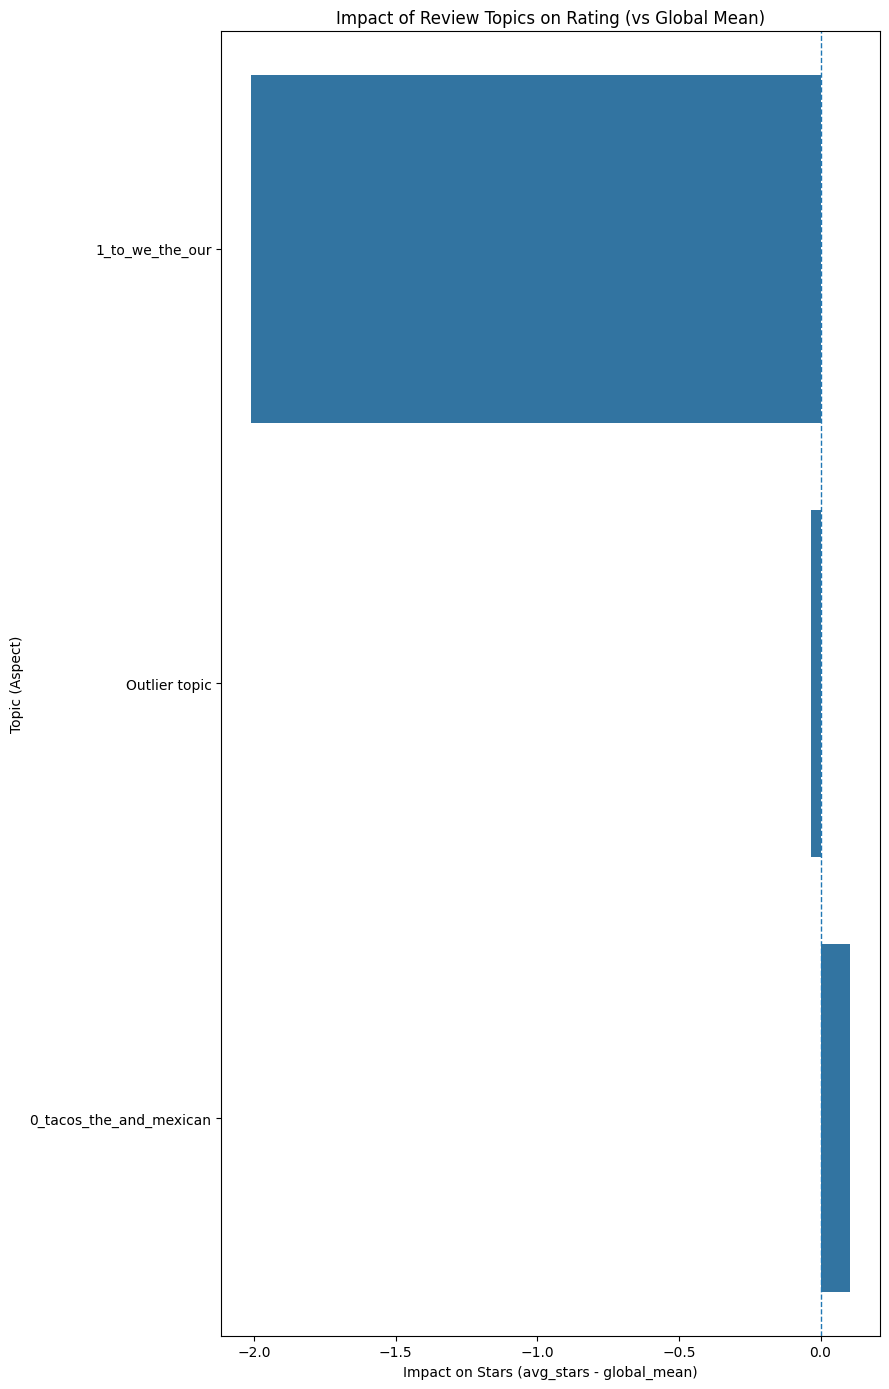

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# If not already computed:
global_mean = restaurants_sample["review_stars"].mean()

# Filter out tiny topics to keep plot readable
min_reviews_topic = 2000   # adjust if needed
plot_topics = topic_stats[topic_stats["n_reviews"] >= min_reviews_topic].copy()

# Sort by impact
plot_topics = plot_topics.sort_values("impact_vs_global")

plt.figure(figsize=(9, 14))
sns.barplot(
    data=plot_topics,
    x="impact_vs_global",
    y="topic_label"
)
plt.axvline(0, linestyle="--", linewidth=1)
plt.title("Impact of Review Topics on Rating (vs Global Mean)")
plt.xlabel("Impact on Stars (avg_stars - global_mean)")
plt.ylabel("Topic (Aspect)")
plt.tight_layout()
plt.show()


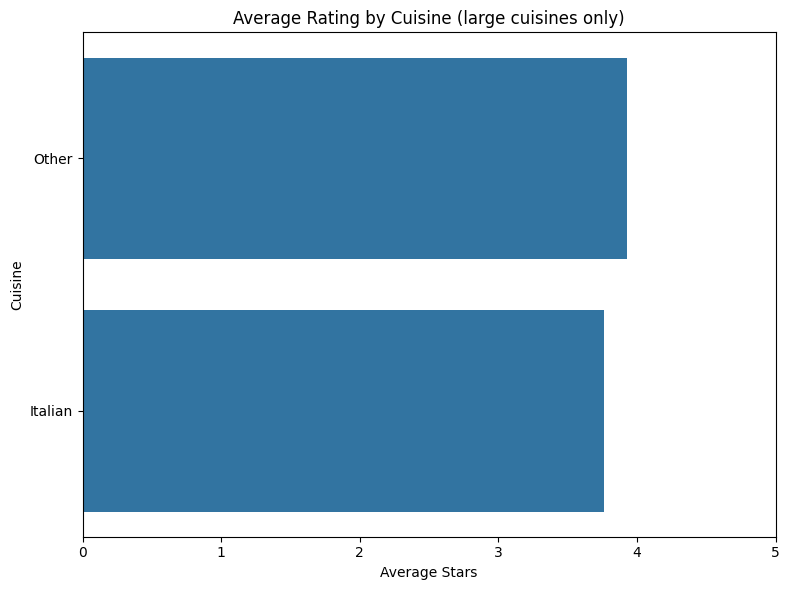

In [ ]:
# If you don’t have it:
cuisine_overall = (
    restaurants_sample
    .groupby("cuisine_cluster")
      .agg(
          avg_stars=("review_stars", "mean"),
            n_reviews=("review_id", "count")
          )
      )

min_reviews_cuisine = 5000  # adjust to focus on big cuisines
plot_cuisines = cuisine_overall[cuisine_overall["n_reviews"] >= min_reviews_cuisine].copy()
plot_cuisines = plot_cuisines.sort_values("avg_stars", ascending=False)

plt.figure(figsize=(8, 6))
sns.barplot(
    data=plot_cuisines,
    x="avg_stars",
    y="cuisine_cluster"
)
plt.title("Average Rating by Cuisine (large cuisines only)")
plt.xlabel("Average Stars")
plt.ylabel("Cuisine")
plt.xlim(0, 5)
plt.tight_layout()
plt.show()


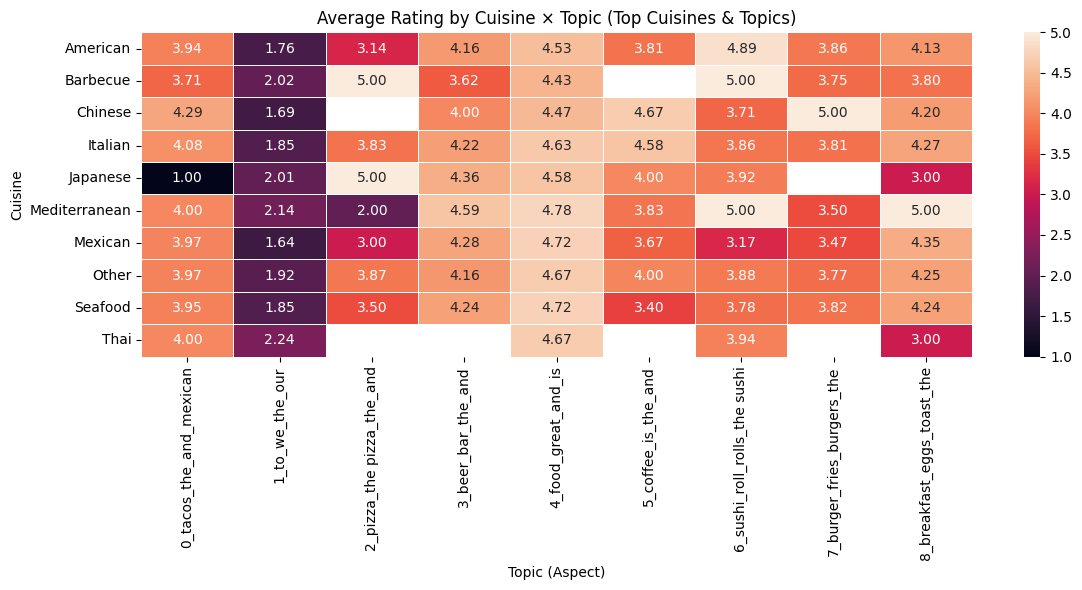

In [ ]:
# 1) choose top cuisines by volume
top_cuisines = (
    restaurants_sample["cuisine_cluster"]
    .value_counts()
    .head(10)
    .index
)

# 2) choose top topics by volume
top_topics = (
    topic_stats
    .sort_values("n_reviews", ascending=False)
    .head(10)["topic_label"]
    .tolist()
)

# 3) filter topic_cuisine_stats to those
heat_df = topic_cuisine_stats[
    topic_cuisine_stats["cuisine_cluster"].isin(top_cuisines)
    & topic_cuisine_stats["topic_label"].isin(top_topics)
].copy()

# 4) pivot for heatmap
pivot = heat_df.pivot(
    index="cuisine_cluster",
    columns="topic_label",
    values="avg_stars"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Average Rating by Cuisine × Topic (Top Cuisines & Topics)")
plt.xlabel("Topic (Aspect)")
plt.ylabel("Cuisine")
plt.tight_layout()
plt.show()


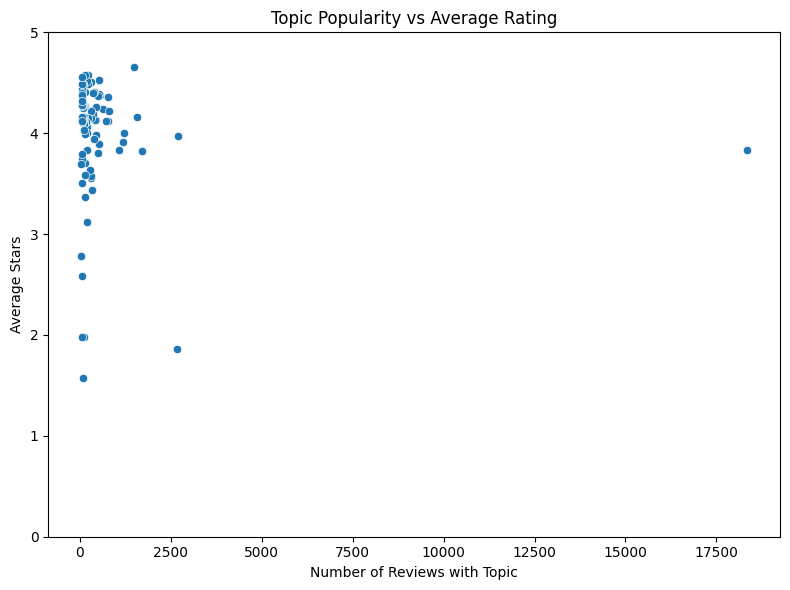

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(
    data=topic_stats,
    x="n_reviews",
    y="avg_stars"
)
plt.title("Topic Popularity vs Average Rating")
plt.xlabel("Number of Reviews with Topic")
plt.ylabel("Average Stars")
plt.ylim(0, 5)
plt.tight_layout()
plt.show()


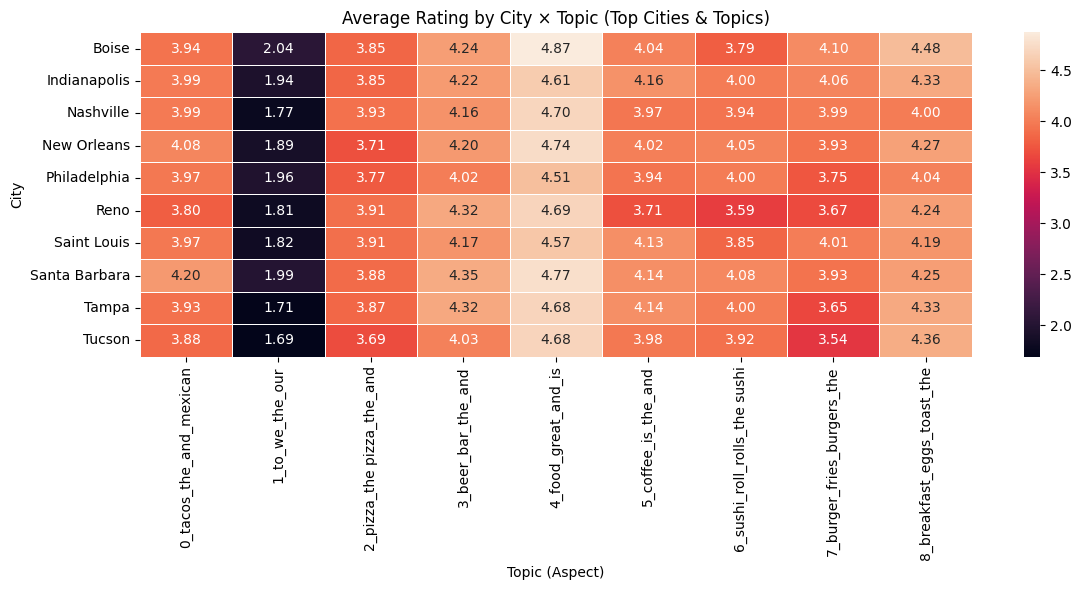

In [ ]:
topic_by_city = (
    restaurants_sample
    .groupby(["city", "topic_label"])
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .reset_index()
)

top_cities = (
    restaurants_sample["city"]
    .value_counts()
    .head(10)
    .index
)

top_topics_city = (
    topic_stats
    .sort_values("n_reviews", ascending=False)
    .head(10)["topic_label"]
    .tolist()
)

heat_city = topic_by_city[
    topic_by_city["city"].isin(top_cities)
    & topic_by_city["topic_label"].isin(top_topics_city)
]

pivot_city = heat_city.pivot(
    index="city",
    columns="topic_label",
    values="avg_stars"
)

plt.figure(figsize=(12, 6))
sns.heatmap(
    pivot_city,
    annot=True,
    fmt=".2f",
    linewidths=0.5
)
plt.title("Average Rating by City × Topic (Top Cities & Topics)")
plt.xlabel("Topic (Aspect)")
plt.ylabel("City")
plt.tight_layout()
plt.show()


In [ ]:
# Ensure we have topic_cuisine_stats (from Step 5)
# Columns: cuisine_cluster, topic_label, avg_stars, n_reviews

# 7A: Find top positive/negative topics per cuisine
def top_topics_for_cuisine(cuisine, N=5):
    df = topic_cuisine_stats[topic_cuisine_stats["cuisine_cluster"] == cuisine].copy()
    df = df[df["n_reviews"] >= 100]   # filter tiny topics

    df["z_score"] = (df["avg_stars"] - df["avg_stars"].mean()) / df["avg_stars"].std()

    top_pos = df.sort_values("z_score", ascending=False).head(N)
    top_neg = df.sort_values("z_score", ascending=True).head(N)

    return top_pos, top_neg

cuisine_list = restaurants_sample["cuisine_cluster"].unique()

final_cuisine_topics = {}

for c in cuisine_list:
    pos, neg = top_topics_for_cuisine(c)
    final_cuisine_topics[c] = {
        "top_positive_topics": pos,
        "top_negative_topics": neg
    }

# Example: print for Mexican food
print("\n🔺 Mexican — Top Positive Topics:")
print(final_cuisine_topics["Mexican"]["top_positive_topics"])

print("\n🔻 Mexican — Top Negative Topics:")
print(final_cuisine_topics["Mexican"]["top_negative_topics"])



🔺 Mexican — Top Positive Topics:
    cuisine_cluster                  topic_label  avg_stars  n_reviews  \
460         Mexican          4_food_great_and_is   4.719697        132   
425         Mexican  14_tucson_in tucson_and_the   4.269939        163   
420         Mexican      0_tacos_the_and_mexican   3.974846       2266   
419         Mexican            -1_the_and_was_to   3.617473        847   
431         Mexican              1_to_we_the_our   1.644231        208   

      z_score  
460  0.903406  
425  0.525249  
420  0.277135  
419 -0.023344  
431 -1.682446  

🔻 Mexican — Top Negative Topics:
    cuisine_cluster                  topic_label  avg_stars  n_reviews  \
431         Mexican              1_to_we_the_our   1.644231        208   
419         Mexican            -1_the_and_was_to   3.617473        847   
420         Mexican      0_tacos_the_and_mexican   3.974846       2266   
425         Mexican  14_tucson_in tucson_and_the   4.269939        163   
460         Mexican  

In [ ]:
# 7B — City × Cuisine × Topic
city_cuisine_topic = (
    restaurants_sample
    .groupby(["city", "cuisine_cluster", "topic_label"])
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .reset_index()
)

# Add impact vs global for interpretability
city_cuisine_topic["impact_vs_global"] = (
    city_cuisine_topic["avg_stars"] - global_mean
)

print(city_cuisine_topic.head())


    city cuisine_cluster                   topic_label  avg_stars  n_reviews  \
0  Boise        American             -1_the_and_was_to    3.47541         61   
1  Boise        American       0_tacos_the_and_mexican    4.50000          2   
2  Boise        American       10_bbq_brisket_ribs_the    2.50000          2   
3  Boise        American  12_brunch_for brunch_the_and    3.00000          1   
4  Boise        American   17_vegan_vegetarian_and_the    5.00000          1   

   impact_vs_global  
0          -0.39515  
1           0.62944  
2          -1.37056  
3          -0.87056  
4           1.12944  


In [ ]:
# 7C — Business-level topic KPI
business_topic_stats = (
    restaurants_sample
    .groupby(["business_id", "name", "city", "cuisine_cluster", "topic_label"])
    .agg(
        avg_stars=("review_stars", "mean"),
        n_reviews=("review_id", "count")
    )
    .reset_index()
)

# Add deviation from global
business_topic_stats["impact_vs_global"] = (
    business_topic_stats["avg_stars"] - global_mean
)

print(business_topic_stats.head())


              business_id                                   name  \
0  --lqIzK-ZVTtgwiQM63XgQ                                Wendy's   
1  -0G_6-KFGpCpxTUlVXCMYQ                               Gio Taco   
2  -0M0b-XhtFagyLmsBtOe8w                         Paris Wine Bar   
3  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits   
4  -0TffRSXXIlBYVbb5AwfTg  IndeBlue Modern Indian Food & Spirits   

           city cuisine_cluster                          topic_label  \
0  Indianapolis        American                    -1_the_and_was_to   
1        Tucson         Mexican              0_tacos_the_and_mexican   
2  Philadelphia           Other                    -1_the_and_was_to   
3  Philadelphia          Indian                    -1_the_and_was_to   
4  Philadelphia          Indian  16_philly_in philly_in_philadelphia   

   avg_stars  n_reviews  impact_vs_global  
0        2.0          1          -1.87056  
1        5.0          1           1.12944  
2        1.0          1   

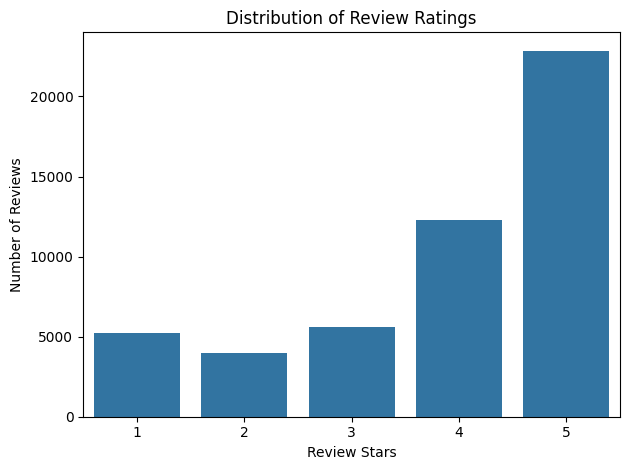

In [ ]:
plt.figure()
sns.countplot(x="review_stars", data=restaurants_sample, order=sorted(restaurants_sample["review_stars"].unique()))
plt.title("Distribution of Review Ratings")
plt.xlabel("Review Stars")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


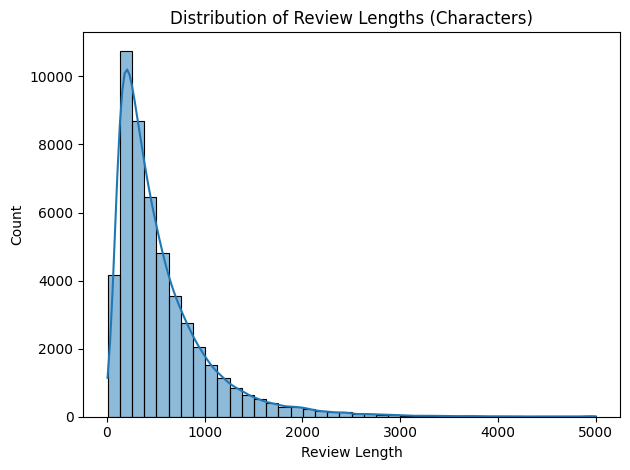

In [ ]:
# Add a review length column if you haven't already
restaurants_sample["review_length"] = restaurants_sample["text"].str.len()

plt.figure()
sns.histplot(restaurants_sample["review_length"], bins=40, kde=True)
plt.title("Distribution of Review Lengths (Characters)")
plt.xlabel("Review Length")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


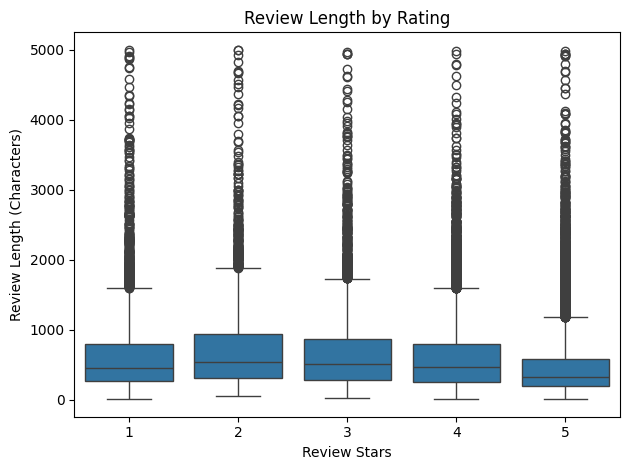

In [ ]:
plt.figure()
sns.boxplot(x="review_stars", y="review_length", data=restaurants_sample)
plt.title("Review Length by Rating")
plt.xlabel("Review Stars")
plt.ylabel("Review Length (Characters)")
plt.tight_layout()
plt.show()


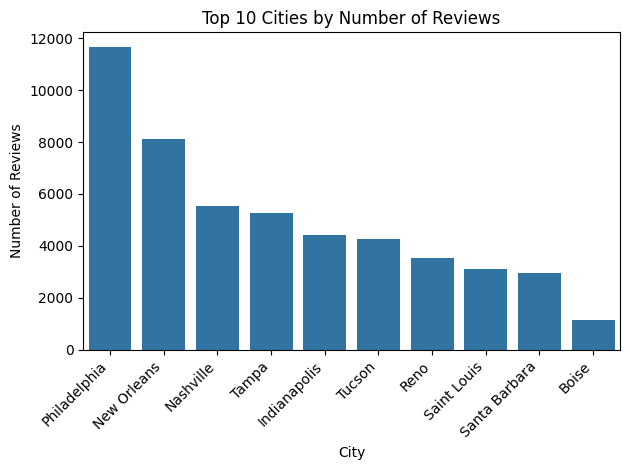

In [ ]:
top_cities = (
    restaurants_sample["city"]
    .value_counts()
    .head(10)
    .index
)

city_counts = (
    restaurants_sample[restaurants_sample["city"].isin(top_cities)]
    ["city"]
    .value_counts()
    .reindex(top_cities)
)

plt.figure()
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.title("Top 10 Cities by Number of Reviews")
plt.xlabel("City")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


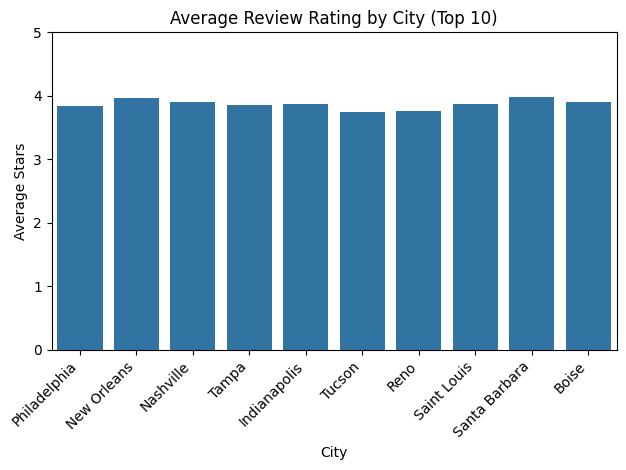

In [ ]:
city_avg = (
    restaurants_sample[restaurants_sample["city"].isin(top_cities)]
    .groupby("city")["review_stars"]
    .mean()
    .reindex(top_cities)
)

plt.figure()
sns.barplot(x=city_avg.index, y=city_avg.values)
plt.title("Average Review Rating by City (Top 10)")
plt.xlabel("City")
plt.ylabel("Average Stars")
plt.ylim(0, 5)
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


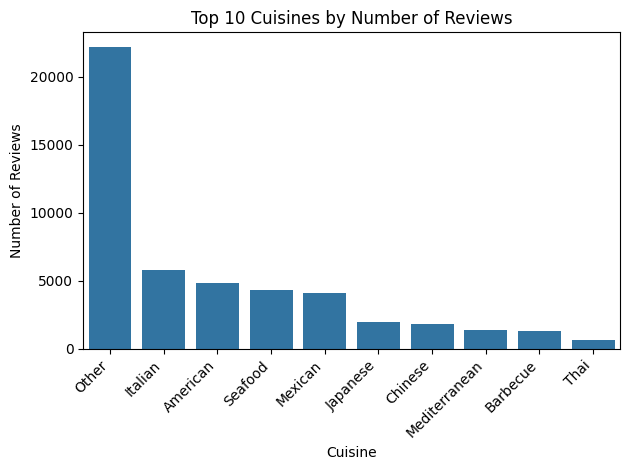

In [ ]:
top_cuisines = (
    restaurants_sample["cuisine_cluster"]
    .value_counts()
    .head(10)
    .index
)

cuisine_counts = (
    restaurants_sample[restaurants_sample["cuisine_cluster"].isin(top_cuisines)]
    ["cuisine_cluster"]
    .value_counts()
    .reindex(top_cuisines)
)

plt.figure()
sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values)
plt.title("Top 10 Cuisines by Number of Reviews")
plt.xlabel("Cuisine")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()


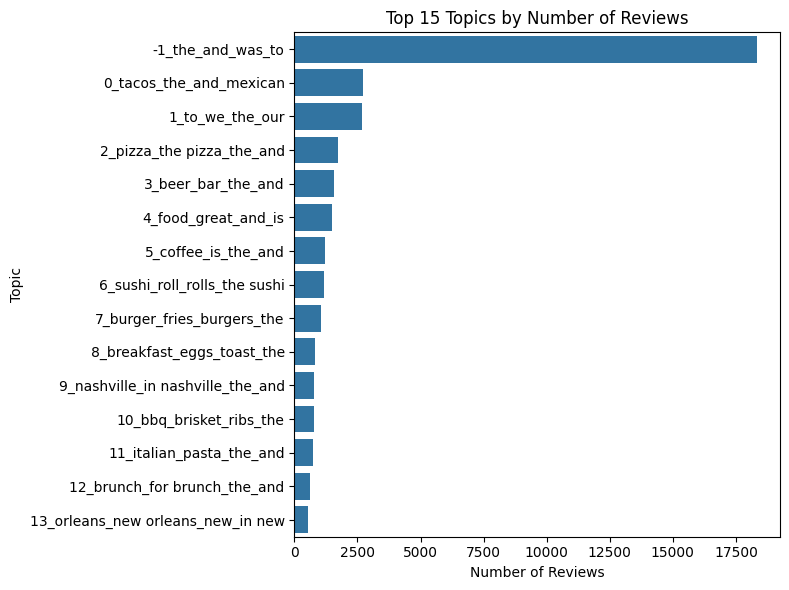

In [ ]:
topic_counts = (
    restaurants_sample["topic_label"]
    .value_counts()
    .head(15)
)

plt.figure(figsize=(8, 6))
sns.barplot(x=topic_counts.values, y=topic_counts.index)
plt.title("Top 15 Topics by Number of Reviews")
plt.xlabel("Number of Reviews")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()


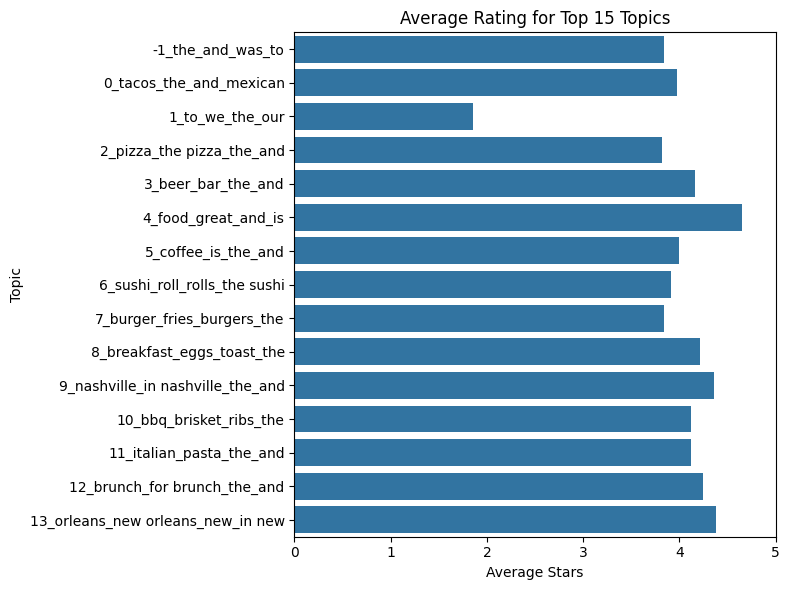

In [ ]:
top_topic_labels = topic_counts.index

topic_avg = (
    restaurants_sample[restaurants_sample["topic_label"].isin(top_topic_labels)]
    .groupby("topic_label")["review_stars"]
    .mean()
    .reindex(top_topic_labels)
)

plt.figure(figsize=(8, 6))
sns.barplot(x=topic_avg.values, y=topic_avg.index)
plt.title("Average Rating for Top 15 Topics")
plt.xlabel("Average Stars")
plt.ylabel("Topic")
plt.xlim(0, 5)
plt.tight_layout()
plt.show()


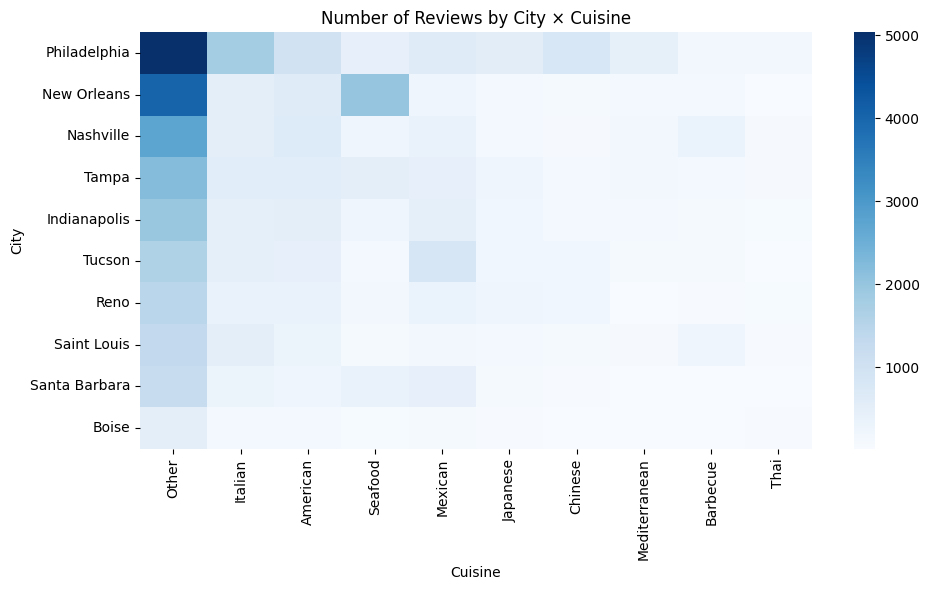

In [ ]:
city_cuisine_pivot = (
    restaurants_sample
    .groupby(["city", "cuisine_cluster"])
    .size()
    .reset_index(name="n_reviews")
    .pivot(index="city", columns="cuisine_cluster", values="n_reviews")
    .fillna(0)
)

# Optional: limit to top 10 cities and top 10 cuisines to keep it readable
top_cities_for_heatmap = top_cities
top_cuisines_for_heatmap = top_cuisines

city_cuisine_pivot = city_cuisine_pivot.loc[top_cities_for_heatmap, top_cuisines_for_heatmap]

plt.figure(figsize=(10, 6))
sns.heatmap(city_cuisine_pivot, annot=False, cmap="Blues")
plt.title("Number of Reviews by City × Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("City")
plt.tight_layout()
plt.show()


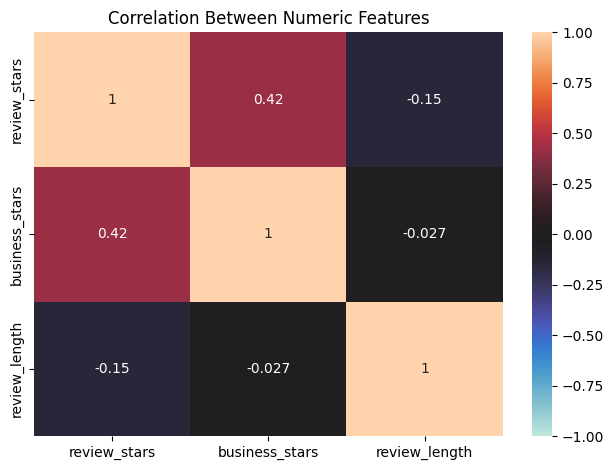

In [ ]:
numeric_cols = ["review_stars", "business_stars", "review_length"]
numeric_cols = [c for c in numeric_cols if c in restaurants_sample.columns]

corr = restaurants_sample[numeric_cols].corr()

plt.figure()
sns.heatmap(corr, annot=True, vmin=-1, vmax=1, center=0)
plt.title("Correlation Between Numeric Features")
plt.tight_layout()
plt.show()


The better visualizations

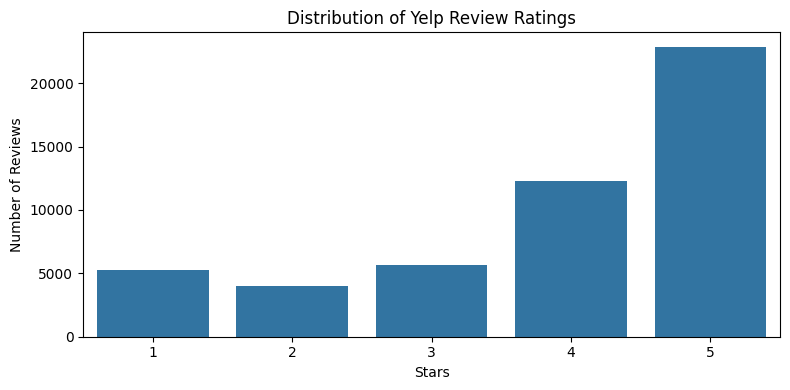

In [ ]:
plt.figure(figsize=(8,4))
sns.countplot(
    x="review_stars",
    data=restaurants_sample,
    order=sorted(restaurants_sample["review_stars"].unique())
)
plt.title("Distribution of Yelp Review Ratings")
plt.xlabel("Stars")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


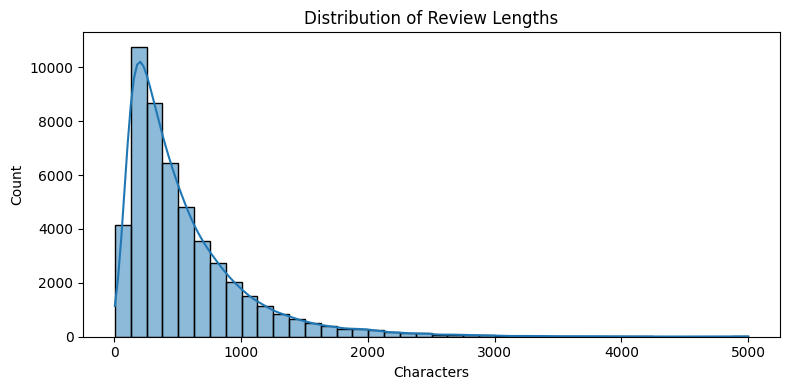

In [ ]:
restaurants_sample["review_length"] = restaurants_sample["text"].str.len()

plt.figure(figsize=(8,4))
sns.histplot(restaurants_sample["review_length"], bins=40, kde=True)
plt.title("Distribution of Review Lengths")
plt.xlabel("Characters")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


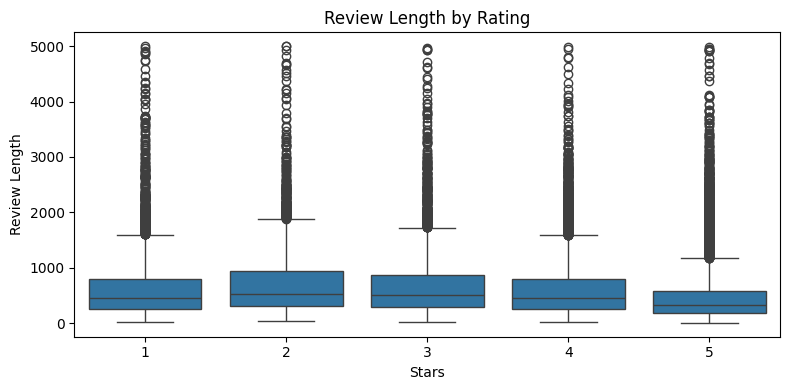

In [ ]:
plt.figure(figsize=(8,4))
sns.boxplot(
    x="review_stars",
    y="review_length",
    data=restaurants_sample
)
plt.title("Review Length by Rating")
plt.xlabel("Stars")
plt.ylabel("Review Length")
plt.tight_layout()
plt.show()


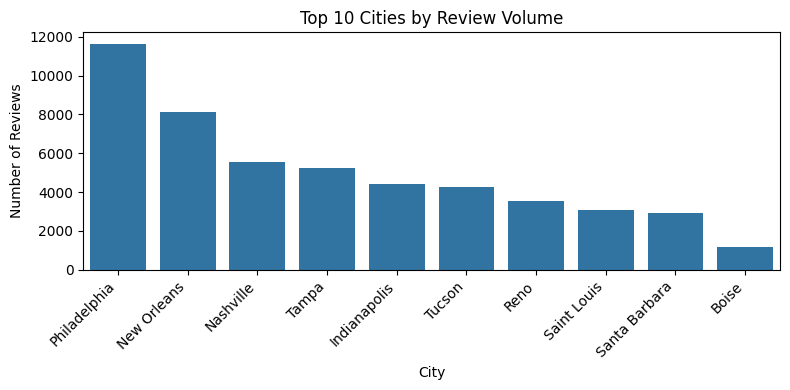

In [ ]:
top_cities = (
    restaurants_sample["city"].value_counts().head(10).index
)

city_counts = (
    restaurants_sample[restaurants_sample["city"].isin(top_cities)]
    ["city"]
    .value_counts()
    .reindex(top_cities)
)

plt.figure(figsize=(8,4))
sns.barplot(x=city_counts.index, y=city_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Cities by Review Volume")
plt.xlabel("City")
plt.ylabel("Number of Reviews")
plt.tight_layout()
plt.show()


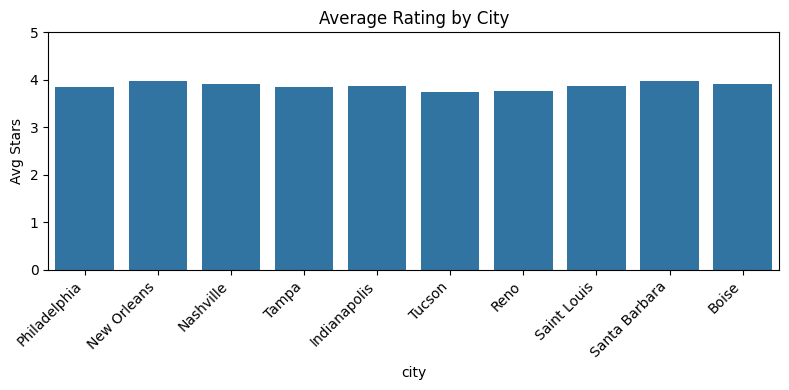

In [ ]:
city_avg = (
    restaurants_sample[restaurants_sample["city"].isin(top_cities)]
    .groupby("city")["review_stars"]
    .mean()
    .reindex(top_cities)
)

plt.figure(figsize=(8,4))
sns.barplot(x=city_avg.index, y=city_avg.values)
plt.xticks(rotation=45, ha="right")
plt.title("Average Rating by City")
plt.ylabel("Avg Stars")
plt.ylim(0,5)
plt.tight_layout()
plt.show()


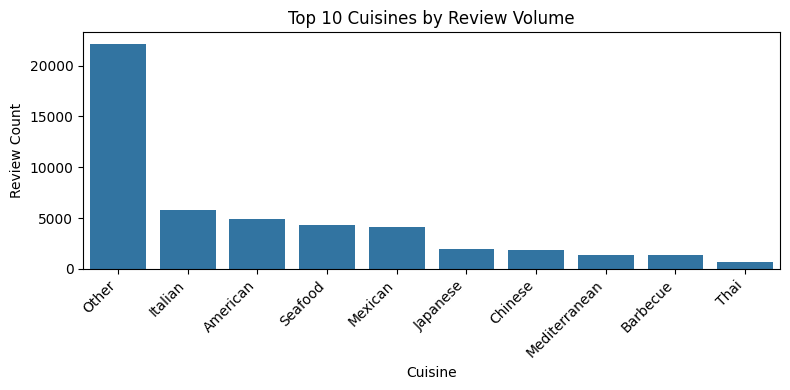

In [ ]:
top_cuisines = (
    restaurants_sample["cuisine_cluster"]
    .value_counts()
    .head(10)
    .index
)

cuisine_counts = (
    restaurants_sample["cuisine_cluster"]
    .value_counts()
    .reindex(top_cuisines)
)

plt.figure(figsize=(8,4))
sns.barplot(x=cuisine_counts.index, y=cuisine_counts.values)
plt.xticks(rotation=45, ha="right")
plt.title("Top 10 Cuisines by Review Volume")
plt.xlabel("Cuisine")
plt.ylabel("Review Count")
plt.tight_layout()
plt.show()


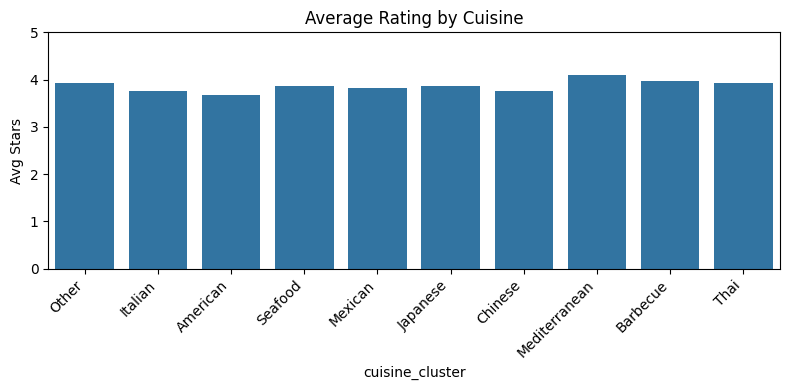

In [ ]:
cuisine_avg = (
    restaurants_sample[restaurants_sample["cuisine_cluster"].isin(top_cuisines)]
    .groupby("cuisine_cluster")["review_stars"]
    .mean()
    .reindex(top_cuisines)
)

plt.figure(figsize=(8,4))
sns.barplot(x=cuisine_avg.index, y=cuisine_avg.values)
plt.xticks(rotation=45, ha="right")
plt.title("Average Rating by Cuisine")
plt.ylabel("Avg Stars")
plt.ylim(0,5)
plt.tight_layout()
plt.show()


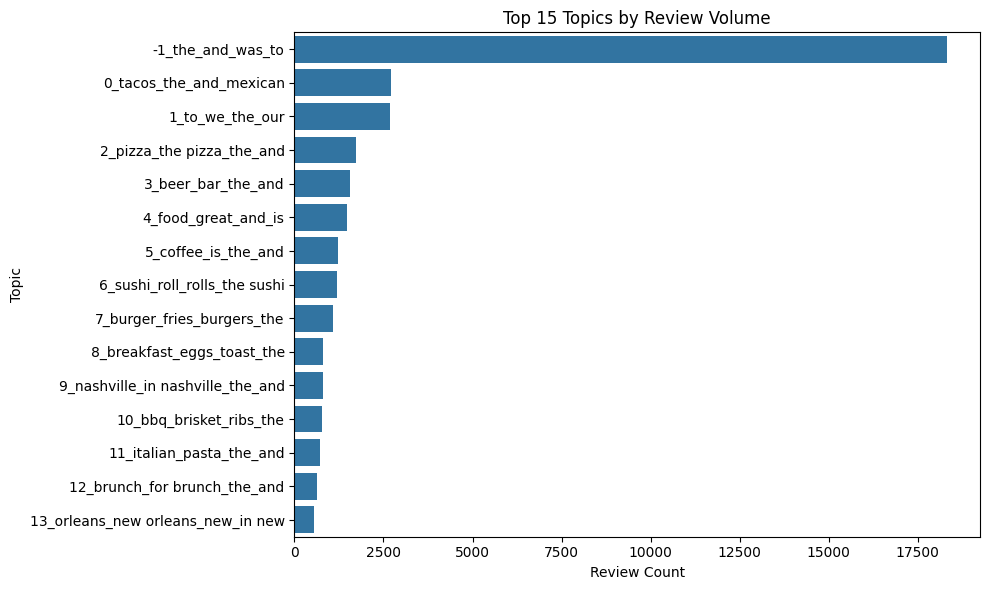

In [ ]:
topic_counts = (
    restaurants_sample["topic_label"]
    .value_counts()
    .head(15)
)

plt.figure(figsize=(10,6))
sns.barplot(x=topic_counts.values, y=topic_counts.index)
plt.title("Top 15 Topics by Review Volume")
plt.xlabel("Review Count")
plt.ylabel("Topic")
plt.tight_layout()
plt.show()



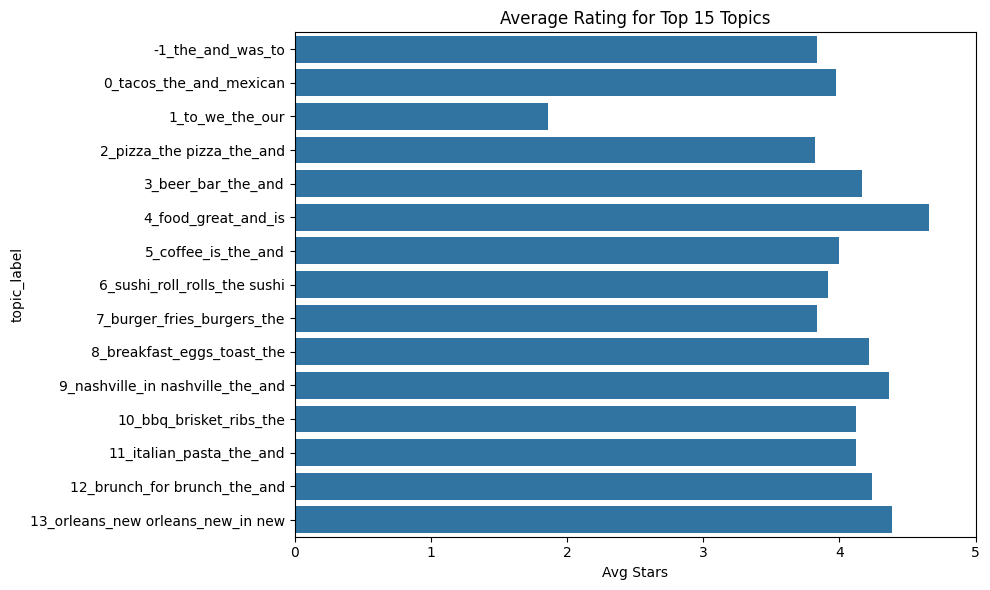

In [ ]:
top_topic_labels = topic_counts.index

topic_avg = (
    restaurants_sample[restaurants_sample["topic_label"].isin(top_topic_labels)]
    .groupby("topic_label")["review_stars"]
    .mean()
    .reindex(top_topic_labels)
)

plt.figure(figsize=(10,6))
sns.barplot(x=topic_avg.values, y=topic_avg.index)
plt.title("Average Rating for Top 15 Topics")
plt.xlabel("Avg Stars")
plt.xlim(0,5)
plt.tight_layout()
plt.show()


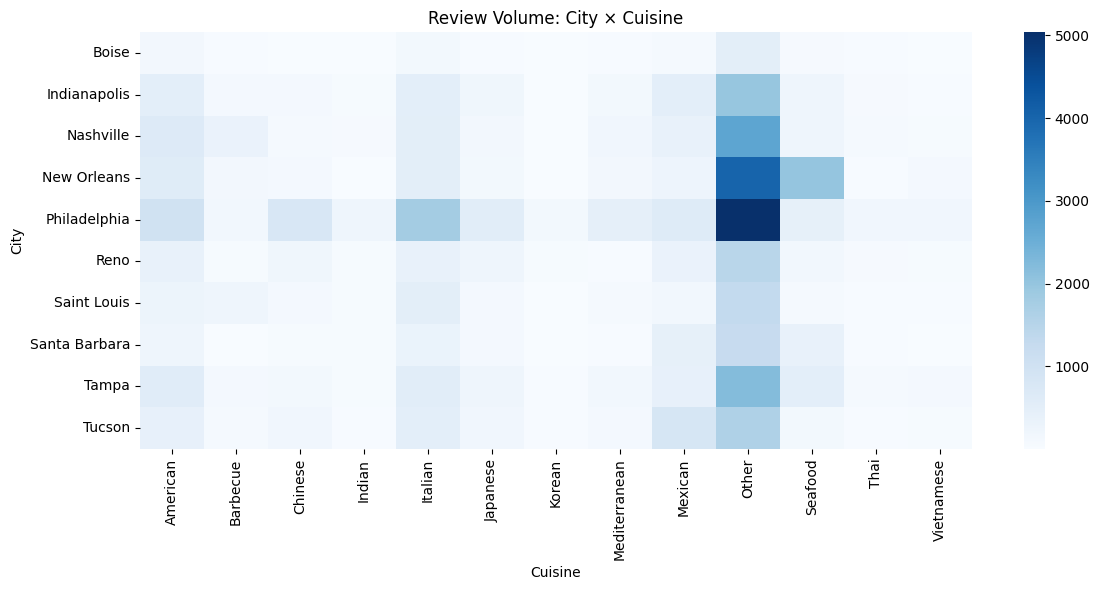

In [ ]:
city_cuisine_pivot = (
    restaurants_sample
    .groupby(["city", "cuisine_cluster"])
    .size()
    .reset_index(name="n_reviews")
    .pivot(index="city", columns="cuisine_cluster", values="n_reviews")
    .fillna(0)
)

plt.figure(figsize=(12,6))
sns.heatmap(city_cuisine_pivot, cmap="Blues")
plt.title("Review Volume: City × Cuisine")
plt.xlabel("Cuisine")
plt.ylabel("City")
plt.tight_layout()
plt.show()


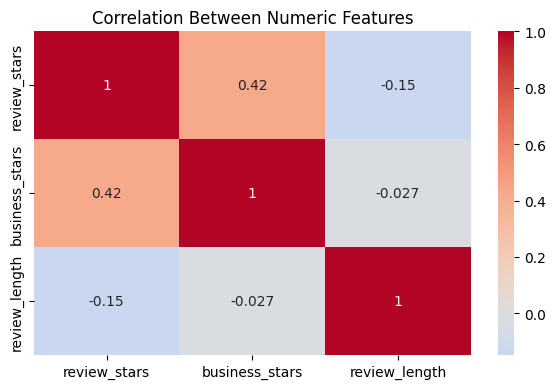

In [ ]:
numeric_cols = ["review_stars", "business_stars", "review_length"]
numeric_cols = [c for c in numeric_cols if c in restaurants_sample.columns]

corr = restaurants_sample[numeric_cols].corr()

plt.figure(figsize=(6,4))
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation Between Numeric Features")
plt.tight_layout()
plt.show()
